In [35]:
import pandas as pd
from collections import Counter
import numpy as np
from pycaret.classification import ClassificationExperiment

- The dataset is from the [American Express - Default Prediction](https://www.kaggle.com/competitions/amex-default-prediction/overview)  kaggle competition. 
- Goal of the competition is predict credit default based on the customer's monthly profile.
- For each customer, 189 features are provided in the dataset

In [4]:
train_data = pd.read_feather("../data/train_data.ftr")

In [5]:
train_data.shape

(5531451, 191)

In [34]:
train_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_140,D_141,D_142,D_143,D_144,D_145,target,Month,Day,Year
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0,3,9,2017
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0,4,7,2017
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0,5,28,2017
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0,6,13,2017
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0,7,16,2017


The features for each customer are divided into the following 5 categories:
  1. D_* = Delinquency variables
  2. S_* = Spend variables
  3. P_* = Payment variables
  4. B_* = Balance variables
  5. R_* = Risk variables

In [7]:
count_of_feature_type = Counter(
    [x.split("_")[0] for x in train_data.columns if x not in ["customer_ID", "target"]]
)
count_of_feature_type = pd.DataFrame(count_of_feature_type, index=["count"]).T
count_of_feature_type

,count
S,22
P,3
D,96
B,40
R,28


0    0.750903
1    0.249097
Name: target, dtype: float64


<AxesSubplot: title={'center': 'Target Distribution'}>

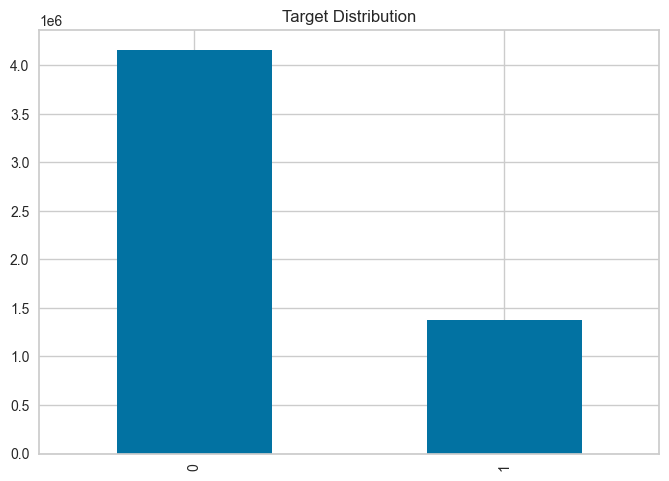

In [8]:
# calculate the percentage of training data that is 1 and 0
print(train_data["target"].value_counts(normalize=True))
train_data["target"].value_counts().plot(kind="bar", title="Target Distribution")

In [9]:
train_data = train_data.sort_values(by=["customer_ID", "S_2"])

In [10]:
# Extract the date information from the date column
train_data["Month"] = [i.month for i in train_data["S_2"]]
train_data["Day"] = [i.day for i in train_data["S_2"]]
train_data["Year"] = [i.year for i in train_data["S_2"]]

In [11]:
# pick random sample of customer_IDs from train_data
np.random.seed(42)
customer_ID_rand = np.random.choice(train_data["customer_ID"], 10000, replace=False)

In [12]:
train_rndm_sample = train_data[train_data["customer_ID"].isin(customer_ID_rand)]

In [13]:
train_rndm_sample.shape

(124538, 194)

In [14]:
# customer_IDs that are not in the random sample for the training data
customer_ID_not_train = list(
    set(train_data["customer_ID"]).difference(set(customer_ID_rand))
)

# pick random sample of customer_IDs from customer_ID_not_train
customer_ID_test_rnd = np.random.choice(customer_ID_not_train, 10000, replace=False)

# test data based on the random sample of customer_IDs
test_rndm_sample = train_data[
    train_data["customer_ID"].isin(customer_ID_test_rnd)
].sort_values(by=["customer_ID", "S_2"])

In [15]:
test_rndm_sample.shape

(120465, 194)

In [16]:
# drop customer_ID and S_2 from train and test data
train_rndm_sample.drop(["customer_ID", "S_2"], axis=1, inplace=True)
test_rndm_sample.drop(["customer_ID", "S_2"], axis=1, inplace=True)

0    0.767212
1    0.232788
Name: target, dtype: float64


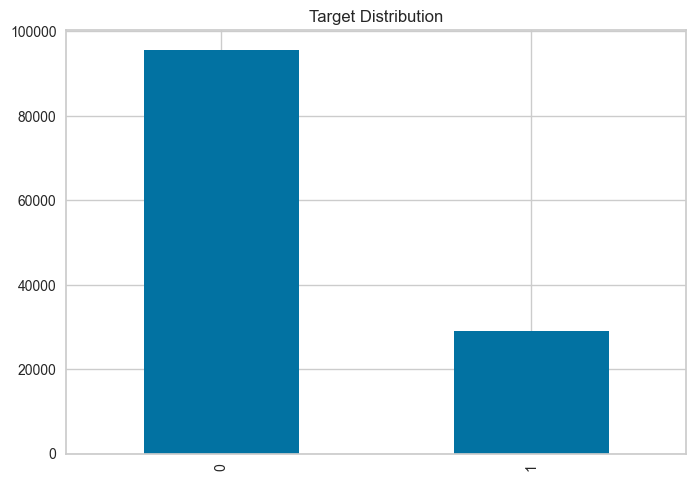

In [17]:
# calculate the percentage of training data sample that is 1 and 0
print(train_rndm_sample["target"].value_counts(normalize=True))
train_rndm_sample["target"].value_counts().plot(kind="bar", title="Target Distribution")

In [18]:
s = ClassificationExperiment()
s.setup(
    data=train_rndm_sample,
    target="target",
    normalize=True,
    session_id=123,
    fix_imbalance=True,
)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(124538, 192)"
4,Transformed data shape,"(171126, 223)"
5,Transformed train set shape,"(133764, 223)"
6,Transformed test set shape,"(37362, 223)"
7,Ordinal features,4
8,Numeric features,180
9,Categorical features,11


In [21]:
s.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [49]:
number_of_models = len(s.models())
compare_models_all = s.compare_models(n_select=number_of_models)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9610,0.9921,0.9448,0.8936,0.9185,0.8928,0.8934,3.9730
knn,K Neighbors Classifier,0.9509,0.9899,0.9757,0.8397,0.9026,0.8700,0.8744,4.6070
catboost,CatBoost Classifier,0.9411,0.9814,0.8670,0.8784,0.8726,0.8343,0.8343,13.5530
xgboost,Extreme Gradient Boosting,0.9251,0.9739,0.8423,0.8372,0.8397,0.7909,0.7909,22.9570
rf,Random Forest Classifier,0.9199,0.9725,0.9058,0.7838,0.8404,0.7873,0.7910,15.3500
lightgbm,Light Gradient Boosting Machine,0.8988,0.9574,0.8075,0.7692,0.7879,0.7214,0.7218,2.4430
gbc,Gradient Boosting Classifier,0.8686,0.9347,0.8075,0.6848,0.7411,0.6539,0.6579,46.4040
dt,Decision Tree Classifier,0.8677,0.8278,0.7530,0.7011,0.7261,0.6390,0.6398,5.4460
lr,Logistic Regression,0.8555,0.9355,0.8836,0.6368,0.7401,0.6437,0.6603,2.2520
ada,Ada Boost Classifier,0.8555,0.9213,0.7849,0.6594,0.7167,0.6207,0.6249,9.5610


Processing:   0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
pred_scores_df = pd.DataFrame()
for x in compare_models_all:
    df_pred = s.predict_model(
        x,
        data=test_rndm_sample,
    )
    x = s.pull()
    pred_scores_df = pd.concat([pred_scores_df, x])

In [66]:
pred_scores_df.sort_values(by=["Accuracy"], ascending=False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8689,0.9321,0.7625,0.7336,0.7477,0.6592,0.6594
0,CatBoost Classifier,0.8678,0.9311,0.7337,0.7442,0.7389,0.6504,0.6505
0,Extreme Gradient Boosting,0.8626,0.9257,0.7224,0.7342,0.7283,0.6363,0.6364
0,Gradient Boosting Classifier,0.8610,0.9279,0.8105,0.6948,0.7482,0.6529,0.6566
0,Random Forest Classifier,0.8600,0.9251,0.8117,0.6921,0.7472,0.6512,0.6551
0,Extra Trees Classifier,0.8559,0.9239,0.7991,0.6867,0.7387,0.6399,0.6435
0,Ada Boost Classifier,0.8512,0.9188,0.8039,0.6747,0.7336,0.6315,0.6362
0,Logistic Regression,0.8501,0.9291,0.8825,0.6522,0.7501,0.6465,0.6616
0,Ridge Classifier,0.8444,0.8619,0.8974,0.6386,0.7462,0.6386,0.6578
0,Linear Discriminant Analysis,0.8444,0.9292,0.8975,0.6386,0.7463,0.6386,0.6579


In [64]:
for model in compare_models_all:
    s.save_model(model, '../models_saved/'+model.__class__.__name__)

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
